### Read in ARTS datasets

In [1]:
import pickle
import pandas as pd
from matcher import get_mapping_of_LF_and_dims
import pandas as pd
import numpy as np
import math
from scipy import stats

resources get initialised


In [2]:
def load_ARTS_data(dims):
    X = []
    y = []

    if dims == 94:
        path_X = f"/workspace/datasets/ARTS/arts94-1249_labels.pkl"        
        path_y = f"/workspace/datasets/ARTS/gpt-4-1106-preview-94_scores.pkl"        
    if dims == 300:
        path_X = f"/workspace/datasets/ARTS/arts300-1249_labels.pkl"        
        path_y = f"/workspace/datasets/ARTS/gpt-4-1106-preview-300_scores.pkl"        
    if dims == 3000:
        path_X = f"/workspace/datasets/ARTS/arts3000-1249_labels.pkl"        
        path_y = f"/workspace/datasets/ARTS/gpt-4-1106-preview-3000_scores.pkl"  

    X_labels = pickle.load(open(path_X, "rb"))
    y_labels = pickle.load(open(path_y, "rb"))

    X = X_labels

    for i in range(len(X)):
        y.append(y_labels[i][0])

    return X, y

In [3]:
arts94_X, arts94_scores = load_ARTS_data(94)
arts300_X, arts300_scores = load_ARTS_data(300)
arts3000_X, arts3000_scores = load_ARTS_data(3000)

In [4]:
dims_to_names, names_to_dims, name_to_thresless, name_to_category, name_to_feature = get_mapping_of_LF_and_dims()

In [5]:
names_to_comp_simp = {}

df_cs = pd.DataFrame(arts3000_X)

for dim in range(len(arts3000_X[0])):
    cnts = df_cs[dim].value_counts()

    name = dims_to_names[dim][0]

    if 0 in cnts:
        names_to_comp_simp[name] = 'simp'
    else:
        if 1 in cnts:
            names_to_comp_simp[name] = 'complex'
        else:
            if 'NOT_SIMPLE' in name:
                names_to_comp_simp[name] = 'complex'
            else:
                if 'SIMPLE' in name:
                    names_to_comp_simp[name] = 'simp'
                else:
                    if 'label=1' in name:
                        names_to_comp_simp[name] = 'complex'
                    else:
                        if 'label=0' in name:
                            names_to_comp_simp[name] = 'simp'
                        else:
                            if dim == 228 or dim == 229 or dim == 230 or dim == 555 or dim == 556 or dim == 557 or dim == 558 or dim == 559 or dim == 560 or dim == 561 or dim == 562 or \
                                dim == 563 or dim == 564 or dim == 565 or dim == 566 or dim == 567 or dim == 568 or dim == 569 or dim == 570 or dim == 571 or dim == 571 or dim == 572 or \
                                dim == 573 or dim == 574 or dim == 990:
                                names_to_comp_simp[name] = 'simp'
                            else:
                                if dim == 985 or dim == 991 or dim == 992 or dim == 993 or dim == 994 or dim == 995 or dim == 1001 or dim == 1002 or dim == 1004 or dim == 1005:
                                    names_to_comp_simp[name] = 'complex'
                                else:
                                    print(dim)
                                    print(name)

cnt_feat = {}
cnt_cat = {}

comp_name_to_feature = {}
simp_name_to_feature = {}

for name in name_to_feature:
    feat = name_to_feature[name]
    if names_to_comp_simp[name] == 'simp':
        simp_name_to_feature[name] = feat
    
        if feat + '_simp' not in cnt_feat:
            cnt_feat[feat + '_simp'] = 1
        else:
            cnt_feat[feat + '_simp'] += 1
    else:
        comp_name_to_feature[name] = feat

        if feat + '_complex' not in cnt_feat:
            cnt_feat[feat + '_complex'] = 1
        else:
            cnt_feat[feat + '_complex'] += 1

comp_name_to_cat = {}
simp_name_to_cat = {}

for name in name_to_category:
    cat = name_to_category[name]
    if names_to_comp_simp[name] == 'simp':
        comp_name_to_cat[name] = cat

        if cat + '_simp' not in cnt_cat:
            cnt_cat[cat + '_simp'] = 1
        else:
            cnt_cat[cat + '_simp'] += 1
    else:
        simp_name_to_cat[name] = cat

        if cat + '_complex' not in cnt_cat:
            cnt_cat[cat + '_complex'] = 1
        else:
            cnt_cat[cat + '_complex'] += 1

In [6]:
print(len(comp_name_to_feature))
print(len(simp_name_to_feature))

560
689


#### remap values in X

In [7]:
def remap(ds):
    arts_X_remapped = []

    for entry in ds:
        vals = []

        for n in entry:
            if n == 0: # simple
                vals.append(1)
            else:
                if n == -1: # abstain 
                    vals.append(0)
                else:
                    if n == 1: # complex
                        vals.append(1)

        arts_X_remapped.append(vals)
        
    return arts_X_remapped

In [8]:
arts3000_X_remapped = remap(arts3000_X)
arts300_X_remapped = remap(arts300_X)
arts94_X_remapped = remap(arts94_X)

#### Create structures containing summed up values for dimensions per representarion

In [9]:
dim_to_name_simp = {}
dim_to_name_comp = {}

In [10]:
def fill_ds_for_arts(artsNUM):
    para_to_dim_simp = {}
    para_to_dim_comp = {}

    inter_to_dim_simp = {}
    inter_to_dim_comp = {}

    feat_to_dim_simp = {}
    feat_to_dim_comp = {}
    cat_to_dim_simp = {}
    cat_to_dim_comp = {}

    inter_simp = set()
    inter_comp = set()

    for i in range(len(artsNUM[0])):
        name = dims_to_names[i][0].strip()
        stance = names_to_comp_simp[name]

        if stance == 'simp':
            if not name in para_to_dim_simp:
                dim_to_name_simp[len(para_to_dim_simp)] = name
                para_to_dim_simp[name] = len(para_to_dim_simp)

            inter = name_to_thresless[name].strip()
            if inter not in inter_to_dim_simp:
                inter_to_dim_simp[inter] = len(inter_to_dim_simp)
                inter_simp.add(inter)

            feat = name_to_feature[name].strip()
            if feat not in feat_to_dim_simp:
                feat_to_dim_simp[feat] = len(feat_to_dim_simp)
            
            cate = name_to_category[name].strip()
            if cate not in cat_to_dim_simp:
                cat_to_dim_simp[cate] = len(cat_to_dim_simp)
        else: 
            if not name in para_to_dim_comp:
                dim_to_name_comp[len(para_to_dim_comp)] = name
                para_to_dim_comp[name] = len(para_to_dim_comp)


            inter = name_to_thresless[name].strip()
            if inter not in inter_to_dim_comp:
                inter_to_dim_comp[inter] = len(inter_to_dim_comp)
                inter_comp.add(inter)

            feat = name_to_feature[name].strip()
            if feat not in feat_to_dim_comp:
                feat_to_dim_comp[feat] = len(feat_to_dim_comp)
            
            cate = name_to_category[name].strip()
            if cate not in cat_to_dim_comp:
                cat_to_dim_comp[cate] = len(cat_to_dim_comp)

    all_para_s = []
    all_para_c = []

    all_int_s = [] # NUM * 72
    all_int_c = [] # NUM * 61

    all_feat_s = [] # NUM * 37
    all_feat_c = [] # NUM * 34

    all_cat_s = [] # NUM * 4
    all_cat_c = [] # NUM * 4

    for i in range(len(artsNUM)):
        all_para_s.append([0] * len(simp_name_to_feature))
        all_para_c.append([0] * len(comp_name_to_feature))

        temp = []
        for i in range(len(inter_simp)):
            temp.append([])
        all_int_s.append(temp)
        
        temp = []
        for i in range(len(inter_comp)):
            temp.append([])
        all_int_c.append(temp)

        temp = []
        for i in range(37):
            temp.append([])
        all_feat_s.append(temp)   

        temp = []
        for i in range(34):
            temp.append([])
        all_feat_c.append(temp)    

        temp = []
        for i in range(4):
            temp.append([])
        all_cat_s.append(temp)
        all_cat_c.append(temp)


    # fill structures
    dataset = artsNUM

    for i in range(len(artsNUM)): # NUM
        for j in range(len(artsNUM[i])): # 1249
            c_val = dataset[i][j]

            c_name = dims_to_names[j][0]
            c_stance = names_to_comp_simp[c_name]

            if c_stance == 'simp':
                c_para = para_to_dim_simp[c_name]
                all_para_s[i][c_para] = c_val
                c_inter = inter_to_dim_simp[name_to_thresless[c_name]]
                all_int_s[i][c_inter].append(c_val)
                c_feat = feat_to_dim_simp[name_to_feature[c_name]]
                all_feat_s[i][c_feat].append(c_val)
                c_cat = cat_to_dim_simp[name_to_category[c_name]]
                all_cat_s[i][c_cat].append(c_val)
            else:
                c_para = para_to_dim_comp[c_name]
                all_para_c[i][c_para] = c_val
                c_inter = inter_to_dim_comp[name_to_thresless[c_name]]
                all_int_c[i][c_inter].append(c_val)
                c_feat = feat_to_dim_comp[name_to_feature[c_name]]
                all_feat_c[i][c_feat].append(c_val)
                c_cat = cat_to_dim_comp[name_to_category[c_name]]
                all_cat_c[i][c_cat].append(c_val)


    for i in range(len(artsNUM)):
        for j in range(len(inter_simp)):
            all_int_s[i][j] = sum(all_int_s[i][j])/len(all_int_s[i][j])

        for j in range(len(inter_comp)):
            all_int_c[i][j] = sum(all_int_c[i][j])/len(all_int_c[i][j])

        for j in range(37):
            tmp = sum(all_feat_s[i][j])/len(all_feat_s[i][j])
            all_feat_s[i][j] = tmp

        for j in range(34):
            if '[' in str(all_feat_c[i][j]):
                all_feat_c[i][j] = sum(all_feat_c[i][j]) / len(all_feat_c[i][j])
            
        for j in range(4):
            all_cat_s[i][j] = sum(all_cat_s[i][j])/len(all_cat_s[i][j])

            if '[' in str(all_cat_c[i][j]):
                all_cat_c[i][j] = sum(all_cat_c[i][j]) / len(all_cat_c[i][j])
            
    all_para_s = pd.DataFrame(all_para_s)
    all_para_c = pd.DataFrame(all_para_c)
    all_inter_s = pd.DataFrame(all_int_s)
    all_inter_c = pd.DataFrame(all_int_c)
    all_feat_s = pd.DataFrame(all_feat_s)
    all_feat_c = pd.DataFrame(all_feat_c)
    all_cat_s = pd.DataFrame(all_cat_s)
    all_cat_c = pd.DataFrame(all_cat_c)

    return all_para_s, all_para_c, all_inter_s, all_inter_c, all_feat_s, all_feat_c, all_cat_s, all_cat_c, feat_to_dim_simp, feat_to_dim_comp, cat_to_dim_simp, cat_to_dim_comp

In [11]:
all_para_s, all_para_c, all_inter_s, all_inter_c, all_feat_s, all_feat_c, all_cat_s, all_cat_c, feat_to_dim_simp, feat_to_dim_comp, cat_to_dim_simp, cat_to_dim_comp = fill_ds_for_arts(arts3000_X_remapped)

In [12]:
final_cor_s = []

for i in all_para_s.columns:
    cor = stats.pearsonr(all_para_s[i], arts3000_scores)[0]
    if not math.isnan(cor):
        final_cor_s.append((cor, i))
    else:
        final_cor_s.append((0, i))

final_cor_c = []

for i in all_para_c.columns:
    cor = stats.pearsonr(all_para_c[i], arts3000_scores)[0]
    if not math.isnan(cor):
        final_cor_c.append((cor, i))
    else:
        final_cor_c.append((0, i))

/usr/local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [13]:
kept_names = []
kept_dim_s = []

for tuple in final_cor_s:
    if tuple[0] <= -0.25:
        kept_dim_s.append(tuple[1])
        kept_names.append(dim_to_name_simp[tuple[1]])

kept_dim_c = []

for tuple in final_cor_c:
    if tuple[0] >= 0.25:
        kept_dim_c.append(tuple[1])
        kept_names.append(dim_to_name_comp[tuple[1]])


In [14]:
print(len(kept_dim_s))
print(len(kept_dim_c))

98
120


In [15]:
merged_vec = []

for i in range(3000):
    kept_dim_vec = []

    for j in all_para_s.columns:
        if j in kept_dim_s:
            kept_dim_vec.append(all_para_s[j][i])

    for j in all_para_c.columns:
        if j in kept_dim_c:
            kept_dim_vec.append(all_para_c[j][i])

    merged_vec.append(kept_dim_vec)

In [16]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier

reg_gb = GradientBoostingRegressor(random_state=42)
reg_rf = RandomForestRegressor(random_state=42)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import pickle

In [17]:
splitperc = int(len(merged_vec)*0.8)

r = reg_rf.fit(merged_vec[:splitperc], arts3000_scores[:splitperc])

pred = r.predict(merged_vec[splitperc:])


msw = mean_absolute_error(pred, arts3000_scores[splitperc:])
print(msw)

print(mean_squared_error(pred, arts3000_scores[splitperc:]))

print(r2_score(pred, arts3000_scores[splitperc:]))



0.18966062794960317
0.05423989762423841
-0.6547101818476422


In [18]:
splitperc = int(len(arts3000_X_remapped)*0.8)

r = reg_rf.fit(arts3000_X_remapped[:splitperc], arts3000_scores[:splitperc])

pred = r.predict(arts3000_X_remapped[splitperc:])


msw = mean_absolute_error(pred, arts3000_scores[splitperc:])
print(msw)

print(mean_squared_error(pred, arts3000_scores[splitperc:]))

print(r2_score(pred, arts3000_scores[splitperc:]))


0.18262854440654758
0.0500787911590324
-0.5117085023091241


In [19]:
from sklearn.utils import shuffle


In [20]:
def reduce_dataset(X):
    reduced_X = []

    for i in range(len(X)):

        curr_ent = []
        for dim in range(len(X[i])):
            c_name = dims_to_names[dim][0]

            tv = c_name in kept_names
            if c_name in kept_names:
                curr_ent.append(X[i][dim])
            
        reduced_X.append(curr_ent)

    return reduced_X

In [21]:
# datasets: list of datasets or single dataset, depending on if multiple_datasets is set to True
# make_categorical_data: transform numeric -1, 0, 1 data to categorical data, for each dimension 2 new ones, 
#       one with either SIMP/NOT_SIMP and one for ABSTAIN
# use1249LFs: use the fully unpruned dataset
def load_data(d_s):
    src = []
    simp = []
    labels = []

    simp_path = f"/workspace/datasets/ds_labels/{d_s}-1249_simp_labels.pkl"        
    src_path = f"/workspace/datasets/ds_labels/{d_s}-1249_src_labels.pkl"  
    
    simp_labels = pickle.load(open(simp_path, "rb"))
    src_labels = pickle.load(open(src_path, "rb")) 

    for entry in simp_labels:
        src.append([number for number in entry.tolist()])

    for entry in src_labels:
        simp.append([number for number in entry.tolist()])

    curr_lab = [0] * len(simp_labels) + [1] * len(simp_labels)
    labels = labels + curr_lab
        
    # load textual data
    if d_s == 'EW-SEW-Turk':
        textual_dataset = pd.read_pickle('/workspace/datasets/ewsewturk/ewsewturk.pkl')
    else: 
        if d_s == 'SemEval_2007':    
            textual_dataset = pd.read_pickle('/workspace/datasets/semeval07/semeval07.pkl')
        else:
            if d_s == 'SimpEval_22':
                textual_dataset = pd.read_pickle('/workspace/datasets/simpeval/simpeval.pkl')
            else:
                textual_dataset = pd.read_pickle('/workspace/datasets/' + d_s + '/' + d_s + '.pkl')

    simp_dup = ~textual_dataset['simp'].duplicated()
    src_dup = ~textual_dataset['src'].duplicated()

    dups = simp_dup & src_dup
    
    num_left = sum(dups)

    data_merged_simp_dedup = []
    data_merged_src_dedup = []
    texts = []

    labels_dedup = []

    for index, val in dups.items():
        if val:
            data_merged_simp_dedup.append(simp[index])
            texts.append(textual_dataset['simp'].iloc[index])
            data_merged_src_dedup.append(src[index])
            texts.append(textual_dataset['src'].iloc[index])

    labels_dedup = [0] * num_left + [1] * num_left

    X, y, texts = shuffle(data_merged_simp_dedup + data_merged_src_dedup, labels_dedup, texts, random_state=42)  

    # remapping
    new_X = []
    for entry in X:
        vals = []

        for n in entry:
            if n == 0: # simple
                vals.append(1)
            else:
                if n == -1: # abstain 
                    vals.append(0)
                else:
                    if n == 1: # complex
                        vals.append(1)
        new_X.append(vals)
    X = new_X
        
    reduced_X = reduce_dataset(X)

    red_dim_names = []
    for dim in range(len(X[0])):
        c_name = dims_to_names[dim][0]

        tv = c_name in kept_names
        if c_name in kept_names:              
            red_dim_names.append(c_name)

    return X, y, reduced_X, red_dim_names

In [22]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

clf_gb = GradientBoostingClassifier(random_state=42)
clf_rf = RandomForestClassifier(random_state=42)

clfs = {'gb': clf_gb, 'rf': clf_rf}


In [23]:
def run_classifiers(run, X, y, run_type, n=10):
    if run:
        output = ''
        kfold = KFold(n_splits=n, shuffle=True, random_state=42)
        for clf in clfs:
            cv_scores = cross_val_score(clfs[clf], X, y, cv=kfold)
            output += clf + ' (' + run_type + ') : '
            output += str(sum(cv_scores)/len(cv_scores)) + '\n'
            output += str(cv_scores) + '\n___\n'
        return output, sum(cv_scores)/len(cv_scores)
    return '', 0

In [24]:
X, y, reduced_X, red_dim_names = load_data('NNSeval')

In [25]:
#print(run_classifiers(True, X, y, 'vanilla', 5)[0])
print(run_classifiers(True, reduced_X, y, 'vanilla', 5)[0])


gb (vanilla) : 0.2928070175438596
[0.29166667 0.32291667 0.30208333 0.28421053 0.26315789]
___
rf (vanilla) : 0.17140350877192984
[0.19791667 0.16666667 0.21875    0.18947368 0.08421053]
___



In [26]:
#all_para_s_94, all_para_c_94, all_inter_s_94, all_inter_c_94, all_feat_s_94, all_feat_c_94, all_cat_s_94, all_cat_c_94, feat_to_dim_simp_94, feat_to_dim_comp_94, cat_to_dim_simp_94, cat_to_dim_comp_94 = fill_ds_for_arts(arts94_X)
#all_para_s_300, all_para_c_300, all_inter_s_300, all_inter_c_300, all_feat_s_300, all_feat_c_300, all_cat_s_300, all_cat_c_300, feat_to_dim_simp_300, feat_to_dim_comp_300, cat_to_dim_simp_300, cat_to_dim_comp_300 = fill_ds_for_arts(arts300_X)

In [27]:
# name_to_thresless, name_to_category, name_to_feature 
# feat_to_dim_simp, feat_to_dim_comp, cat_to_dim_simp, cat_to_dim_comp
# names_to_comp_simp
def map_name_to_dim(red_dim_names):
    sim_para_2_dim = {}
    com_para_2_dim = {}
    
    sim_inter_2_dim = {}
    sim_inter = {}
    com_inter_2_dim = {}
    com_inter = {}

    sim_feat_2_dim = {}
    sim_feat = {}
    com_feat_2_dim = {}
    com_feat = {}

    sim_cat_2_dim = {}
    sim_cat = {}
    com_cat_2_dim = {}
    com_cat = {}



    for i in range(len(red_dim_names)):
        name = red_dim_names[i].strip()
        inter = name_to_thresless[name]
        feat = name_to_feature[name]
        cat = name_to_category[name]

        stance = names_to_comp_simp[name]

        if stance == 'simp':
            sim_para_2_dim[name] = len(sim_para_2_dim)

            if inter in sim_inter:
                sim_inter_2_dim[name] = sim_inter[inter]
            else:
                c_len = len(sim_inter)
                sim_inter_2_dim[name] = c_len
                sim_inter[inter] = c_len
                
            if feat in sim_feat:
                sim_feat_2_dim[name] = sim_feat[feat]
            else:
                c_len = len(sim_feat)
                sim_feat_2_dim[name] = c_len
                sim_feat[feat] = c_len

            if cat in sim_cat:
                sim_cat_2_dim[name] = sim_cat[cat]
            else:
                c_len = len(sim_cat)
                sim_cat_2_dim[name] = c_len
                sim_cat[cat] = c_len

        
        else:
            com_para_2_dim[name] = len(com_para_2_dim)

            if inter in com_inter:
                com_inter_2_dim[name] = com_inter[inter]
            else:
                c_len = len(com_inter)
                com_inter_2_dim[name] = c_len
                com_inter[inter] = c_len
                
            if feat in com_feat:
                com_feat_2_dim[name] = com_feat[feat]
            else:
                c_len = len(com_feat)
                com_feat_2_dim[name] = c_len
                com_feat[feat] = c_len

            if cat in com_cat:
                com_cat_2_dim[name] = com_cat[cat]
            else:
                c_len = len(com_cat)
                com_cat_2_dim[name] = c_len
                com_cat[cat] = c_len

    return sim_para_2_dim, com_para_2_dim, sim_inter_2_dim, com_inter_2_dim, sim_feat_2_dim, com_feat_2_dim, sim_cat_2_dim, com_cat_2_dim


In [28]:
sim_para_2_dim, com_para_2_dim, sim_inter_2_dim, com_inter_2_dim, sim_feat_2_dim, com_feat_2_dim, sim_cat_2_dim, com_cat_2_dim = map_name_to_dim(red_dim_names)

In [29]:
def fill_ds_for_datasets(d_s):
    print(len(d_s))
    # num dim per level + stance
    max_param_s = 0
    max_param_c = 0

    for e in sim_para_2_dim:
        if sim_para_2_dim[e] > max_param_s:
            max_param_s = sim_para_2_dim[e]
    for e in com_para_2_dim:
        if com_para_2_dim[e] > max_param_c:
            max_param_c = com_para_2_dim[e]

    max_inter_s = 0
    max_inter_c = 0

    for e in sim_inter_2_dim:
        if sim_inter_2_dim[e] > max_inter_s:
            max_inter_s = sim_inter_2_dim[e]
    for e in com_inter_2_dim:
        if com_inter_2_dim[e] > max_inter_c:
            max_inter_c = com_inter_2_dim[e]

    max_feat_s = 0
    max_feat_c = 0

    for e in sim_feat_2_dim:
        if sim_feat_2_dim[e] > max_feat_s:
            max_feat_s = sim_feat_2_dim[e]
    for e in com_feat_2_dim:
        if com_feat_2_dim[e] > max_feat_c:
            max_feat_c = com_feat_2_dim[e]

    max_cat_s = 0
    max_cat_c = 0

    for e in sim_cat_2_dim:
        if sim_cat_2_dim[e] > max_cat_s:
            max_cat_s = sim_cat_2_dim[e]
    for e in com_cat_2_dim:
        if com_cat_2_dim[e] > max_cat_c:
            max_cat_c = com_cat_2_dim[e]


    all_para_s = []
    all_para_c = []

    all_int_s = []
    all_int_c = []

    all_feat_s = []
    all_feat_c = []

    all_cat_s = []
    all_cat_c = []

    for i in range(len(d_s)):
        all_para_s.append([0] * (max_param_s + 1))
        all_para_c.append([0] * (max_param_c + 1))

        temp = []
        for i in range(max_inter_s + 1):
            temp.append([])
        all_int_s.append(temp)
        
        temp = []
        for i in range(max_inter_c + 1):
            temp.append([])
        all_int_c.append(temp)

        temp = []
        for i in range(max_feat_s + 1):
            temp.append([])
        all_feat_s.append(temp)   

        temp = []
        for i in range(max_feat_c + 1):
            temp.append([])
        all_feat_c.append(temp)    

        temp = []
        for i in range(max_cat_c + 1):
            temp.append([])
        all_cat_s.append(temp)
        all_cat_c.append(temp)

    # fill structures
    dataset = d_s

    for i in range(len(d_s)): # NUM
        for j in range(len(d_s[i])): # reduced number of dimensions
            c_val = dataset[i][j]

            c_name = red_dim_names[j]
            c_stance = names_to_comp_simp[c_name]

            if c_stance == 'simp':
                c_para = sim_para_2_dim[c_name]
                all_para_s[i][c_para] = c_val
                c_inter = sim_inter_2_dim[c_name]
                all_int_s[i][c_inter].append(c_val)
                c_feat = sim_feat_2_dim[c_name]
                all_feat_s[i][c_feat].append(c_val)
                c_cat = sim_cat_2_dim[c_name]
                all_cat_s[i][c_cat].append(c_val)
            else:
                c_para = com_para_2_dim[c_name]
                all_para_c[i][c_para] = c_val
                c_inter = com_inter_2_dim[c_name]
                all_int_c[i][c_inter].append(c_val)
                c_feat = com_feat_2_dim[c_name]
                all_feat_c[i][c_feat].append(c_val)
                c_cat = com_cat_2_dim[c_name]
                all_cat_c[i][c_cat].append(c_val)


    for i in range(len(d_s)):

        for j in range((max_inter_s + 1)):
            all_int_s[i][j] = sum(all_int_s[i][j])/len(all_int_s[i][j])

        for j in range((max_inter_c + 1)):
            all_int_c[i][j] = sum(all_int_c[i][j])/len(all_int_c[i][j])

        for j in range((max_feat_s + 1)):
            tmp = sum(all_feat_s[i][j])/len(all_feat_s[i][j])
            all_feat_s[i][j] = tmp

        for j in range((max_feat_c + 1)):
            if len(all_feat_c[i][j]) > 0:
                all_feat_c[i][j] = sum(all_feat_c[i][j]) / len(all_feat_c[i][j])
            else:
                all_feat_c[i][j] = 0
            
        for j in range(max_cat_s + 1):
            if '[' in str(all_cat_s[i][j]):
                all_cat_s[i][j] = sum(all_cat_s[i][j])/len(all_cat_s[i][j])

        for j in range(max_cat_c + 1):

            if '[' in str(all_cat_c[i][j]):
                all_cat_c[i][j] = sum(all_cat_c[i][j]) / len(all_cat_c[i][j])


    all_para_s = pd.DataFrame(all_para_s)
    all_para_c = pd.DataFrame(all_para_c)
    all_inter_s = pd.DataFrame(all_int_s)
    all_inter_c = pd.DataFrame(all_int_c)
    all_feat_s = pd.DataFrame(all_feat_s)
    all_feat_c = pd.DataFrame(all_feat_c)
    all_cat_s = pd.DataFrame(all_cat_s)
    all_cat_c = pd.DataFrame(all_cat_c)

    return all_para_s, all_para_c, all_inter_s, all_inter_c, all_feat_s, all_feat_c, all_cat_s, all_cat_c, feat_to_dim_simp, feat_to_dim_comp, cat_to_dim_simp, cat_to_dim_comp

In [30]:
all_para_s, all_para_c, all_inter_s, all_inter_c, all_feat_s, all_feat_c, all_cat_s, all_cat_c, feat_to_dim_simp, feat_to_dim_comp, cat_to_dim_simp, cat_to_dim_comp = fill_ds_for_datasets(reduced_X)


478


In [31]:
reduced_arts3000X_remapped = reduce_dataset(arts3000_X_remapped)

all_para_s_3000, all_para_c_3000, all_inter_s_3000, all_inter_c_3000, all_feat_s_3000, all_feat_c_3000, all_cat_s_3000, all_cat_c_3000, feat_to_dim_simp, feat_to_dim_comp, cat_to_dim_simp, cat_to_dim_comp = fill_ds_for_datasets(reduced_arts3000X_remapped)


3000


In [32]:
reduced_arts300X_remapped = reduce_dataset(arts300_X_remapped)

all_para_s_300, all_para_c_300, all_inter_s_300, all_inter_c_300, all_feat_s_300, all_feat_c_300, all_cat_s_300, all_cat_c_300, feat_to_dim_simp, feat_to_dim_comp, cat_to_dim_simp, cat_to_dim_comp = fill_ds_for_datasets(reduced_arts300X_remapped)


reduced_arts94X_remapped = reduce_dataset(arts94_X_remapped)

all_para_s_94, all_para_c_94, all_inter_s_94, all_inter_c_94, all_feat_s_94, all_feat_c_94, all_cat_s_94, all_cat_c_94, feat_to_dim_simp, feat_to_dim_comp, cat_to_dim_simp, cat_to_dim_comp = fill_ds_for_datasets(reduced_arts94X_remapped)

300
94


#### Visualisation

In [33]:
import math
from scipy import stats
import seaborn as sns

In [34]:
def get_data(simple, rep):
    if simple:
        if rep == 'para':
            curr_94 = all_para_s_94
            curr_300 = all_para_s_300
            curr_3000 = all_para_s_3000

            title = 'Importance of Parametrisations (simple)'
            sns.set(rc = {'figure.figsize':(5,15)})

        if rep == 'inter':
            curr_94 = all_inter_s_94
            curr_300 = all_inter_s_300
            curr_3000 = all_inter_s_3000

            title = 'Importance of Interpretations (simple)'
            sns.set(rc = {'figure.figsize':(5,2.5)})

        if rep == 'feat':
            curr_94 = all_feat_s_94
            curr_300 = all_feat_s_300
            curr_3000 = all_feat_s_3000

            title = 'Importance of Features (simple)'

            sns.set(rc = {'figure.figsize':(5,2.5)})

        if rep == 'cat':
            curr_94 = all_cat_s_94
            curr_300 = all_cat_s_300
            curr_3000 = all_cat_s_3000

            title = 'Importance of Categories (simple)'             

            sns.set(rc = {'figure.figsize':(5,1)})
    else:
        if rep == 'para':
            curr_94 = all_para_c_94
            curr_300 = all_para_c_300
            curr_3000 = all_para_c_3000

            title = 'Importance of Parametrisations (complex)'

            sns.set(rc = {'figure.figsize':(5,15)})

        if rep == 'inter':
            curr_94 = all_inter_c_94
            curr_300 = all_inter_c_300
            curr_3000 = all_inter_c_3000

            title = 'Importance of Interpretations (complex)'

            sns.set(rc = {'figure.figsize':(5,2.5)})

        if rep == 'feat':
            curr_94 = all_feat_c_94
            curr_300 = all_feat_c_300
            curr_3000 = all_feat_c_3000

            title = 'Importance of Features (complex)'

            sns.set(rc = {'figure.figsize':(5,2.5)})
        if rep == 'cat':
            curr_94 = all_cat_c_94
            curr_300 = all_cat_c_300
            curr_3000 = all_cat_c_3000

            title = 'Importance of Categories (complex)'             

            sns.set(rc = {'figure.figsize':(5,1)})  

    vals94 = []
    for i in curr_94.columns:
        vals94.append(sum(curr_94[i])/len(curr_94[i]))
    
    vals300 = []
    for i in curr_300.columns:
        vals300.append(sum(curr_300[i])/len(curr_300[i]))

    vals3000 = []
    for i in curr_3000.columns:
        vals3000.append(sum(curr_3000[i])/len(curr_3000[i]))

    return vals94, vals300, vals3000, title

98


Text(0.5, 1.0, 'Importance of Parametrisations (simple)')

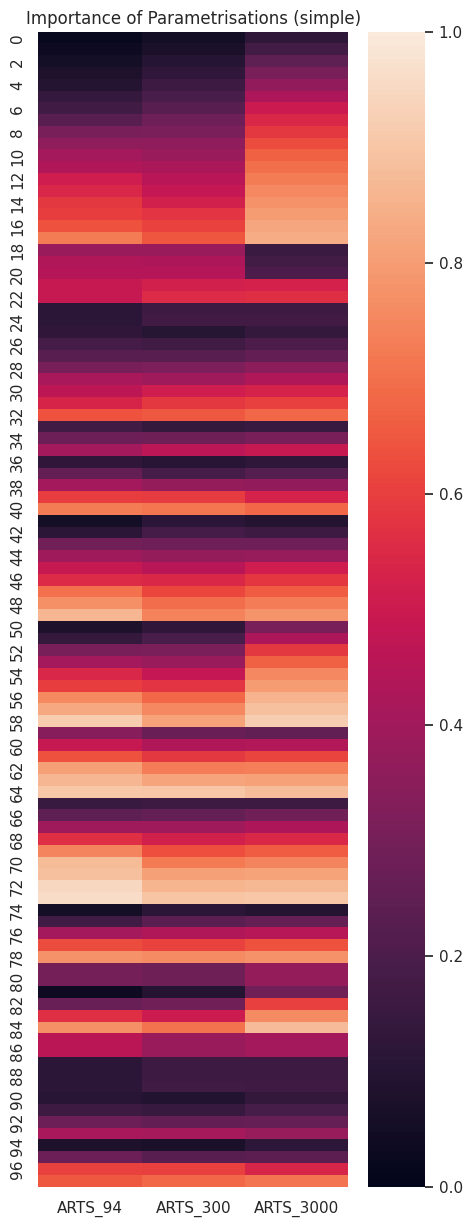

In [39]:
simple = True
rep = 'para'
cors94, cors300, cors3000, title = get_data(simple, rep)


print(len(cors94))

para_df = pd.DataFrame({'ARTS_94': cors94, 'ARTS_300': cors300, 'ARTS_3000': cors3000})


new_df = []

#for i, r in para_df.iterrows():
    # filter lfs raus


sns.heatmap(para_df, vmin=0, vmax=1).set_title(title)

#### RQ 1: which Param/Inter/Feat/Cat are true in most cases?

In [80]:
simple = False
rep = 'feat'
#mapping = sim_para_2_dim
mapping = com_feat_2_dim


cors94, cors300, cors3000, title = get_data(simple, rep)


para_df = pd.DataFrame({'ARTS_94': cors94, 'ARTS_300': cors300, 'ARTS_3000': cors3000})

sets = {'ARTS_94': set(), 'ARTS_300': set(), 'ARTS_3000': set()}

for setting in para_df.columns:
    rows = para_df.nlargest(5, setting)
    for i, r in rows.iterrows():
        for entry in mapping:
            if mapping[entry] == i:
                sets[setting].add(name_to_feature[entry])


intersect = sets['ARTS_94'].intersection(sets['ARTS_300']).intersection(sets['ARTS_3000'])

print(str(intersect)[2:-2].replace("'", '').replace('_', '$\_$'))

print(str(sets['ARTS_94'].difference(intersect))[2:-2].replace("'", '').replace('_', '$\_$'))
print(str(sets['ARTS_300'].difference(intersect))[2:-2].replace("'", '').replace('_', '$\_$'))
print(str(sets['ARTS_3000'].difference(intersect))[2:-2].replace("'", '').replace('_', '$\_$'))


few infrequent words, low age of acquisition, few words per sentence
average lexical richness, high Flesch reading ease
average lexical richness, short sentences
high imageability, high Flesch reading ease


#### RQ 2